# Выпускной проект: основная часть

## Описание проекта

Ранее было проведено исследование оттока клиентов банка "Метанпромбанк", составлены дэшборды и выделены сегменты, однако клиентская база поменялась, поэтому текущие решения перестали работать. В банке повысился отток клиентов, поэтому отдел маркетинга запросил провести исследование, выявить причины оттока, а также понять, с какими категориями клиентов стоит поработать для снижения оттока.

**Цель проекта** - разработать рекомендации для снижения оттока клиентов банка.

**Задачи**:
1. Загрузить, описать и подготовить поступившие данные
2. Провести исследовательский анализ данных (EDA)
3. Проверить статистические гипотезы о влиянии дохода и кредитного рейтинга на лояльность клиентов
4. Выделить признаки, влияющие на отток
5. Сегментировать клиентов
6. Приоретизировать сегменты
7. Разработать рекомендации для снижения оттока в разрезе сегментов

**Описание данных**

В нашем распоряжении имеется таблица ``bank_scrooge.csv``:
- ``USERID`` — идентификатор пользователя,
- ``score`` — баллы кредитного скоринга,
- ``city`` — город,
- ``gender`` - пол,
- ``age`` — возраст,
- ``equity`` — количество баллов собственности,
- ``balance`` — баланс на счёте,
- ``products`` — количество продуктов, которыми пользуется клиент,
- ``credit_card`` — имеется ли кредитная карта
- ``last_activity`` — активный клиент,
- ``EST_SALARY`` — оценочный доход клиента
- ``churn`` — признак оттока

## Ознакомление с данными

In [1]:
# импорт библиотек
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
import itertools

pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option('display.max_colwidth', False)

In [2]:
# устанавливаем библиотеку phik
!pip install phik

     |████████████████████████████████| 686 kB 2.1 MB/s eta 0:00:01


In [3]:
import phik
from phik import resources, report

In [4]:
# загрузка данных
df = pd.read_csv('/datasets/bank_scrooge.csv')

# присвоим имя датафрейму
df.name = 'customers'

In [5]:
# выведем информацию о датафрейме df_logs

# 5 рандомных строк
print('-' * 5, 'Таблица', df.name, '-' * 5)
display(df.sample(5))
    
# общая информация
print('-' * 5, 'Общая информация о "', df.name, '"', '-' * 5, '\n')
df.info()

# описательная статистика
print('\n', '-' * 5, 'Описательная статистика о "', df.name, '"', '-' * 5, '\n')
display(df.describe(percentiles=[0.05, 1/4, 1/2, 3/4, 0.95]))
    
# пропуски
print('\n', '-' * 5, 'Пропуски в "', df.name, '"', '-' * 5, '\n')
    
if df.isna().sum().sum() != 0:
    display(df.isna().sum().sort_values(ascending = False))
    print(f'Средний процент пропусков составил: {(df.isna().sum()/len(df)*100).mean():.2f}%')
else:
    print('Пропусков не найдено \n')
        
# дубликаты
print('-' * 5, 'Информация о дубликатах в "', df.name, '"', '-' * 5, '\n')
print('Количество явных дубликатов:', df.duplicated().sum(), '\n')

----- Таблица customers -----


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
4579,122006,908.00,Ярославль,М,31.00,0,NaN,1,1,0,196568.75,0
5125,160073,901.00,Рыбинск,Ж,48.00,5,832477.14,2,1,1,121799.62,0
4732,152597,908.00,Ярославль,М,37.00,0,NaN,1,1,0,113432.14,0
3838,213401,652.00,Рыбинск,М,40.00,0,NaN,1,1,0,206397.27,0
4021,189298,913.00,Ярославль,Ж,43.00,5,5947757.17,2,1,0,995109.01,0


----- Общая информация о " customers " ----- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB

 ----- Описательная статистика о " customers " ----- 



,USERID,score,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
count,10000.00,10000.00,9974.00,10000.00,7705.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,171814.71,848.70,42.73,2.63,827794.31,1.87,0.68,0.52,147866.89,0.18
std,33708.24,65.45,12.18,1.98,1980614.15,0.79,0.47,0.50,139388.51,0.39
min,94561.00,642.00,18.00,0.00,0.00,0.00,0.00,0.00,2546.30,0.00
5%,119176.40,737.00,26.00,0.00,100104.32,1.00,0.00,0.00,32163.97,0.00
25%,142810.25,802.00,33.00,0.00,295554.16,1.00,0.00,0.00,75251.90,0.00
50%,172728.00,853.00,40.00,3.00,524272.20,2.00,1.00,1.00,119658.10,0.00
75%,201261.75,900.00,51.00,4.00,980705.85,2.00,1.00,1.00,174500.54,0.00
95%,223623.05,946.00,65.00,5.00,2116704.78,3.00,1.00,1.00,316885.34,1.00
max,229145.00,1000.00,86.00,9.00,119113552.01,5.00,1.00,1.00,1395064.45,1.00



 ----- Пропуски в " customers " ----- 



balance          2295
age              26  
USERID           0   
score            0   
city             0   
gender           0   
equity           0   
products         0   
credit_card      0   
last_activity    0   
EST_SALARY       0   
churn            0   
dtype: int64

Средний процент пропусков составил: 1.93%
----- Информация о дубликатах в " customers " ----- 

Количество явных дубликатов: 0 



**Вывод**
1. В таблице 10000 записей
2. Пропуски в `balance` (23%) и в `age` (0.26%)
3. Явные дубликаты отсутствуют
4. Некоторые наименования столбцов не приведены к стилю snake_case
5. Подозрительно, что в `products` присутствуют нулевые значения. Возможно, следует избавиться от этих записей.

## Предобработка данных

Сначала приведем наименования столбцов к общепринятому стилю snack_case, далее выясним природу пропусков перед их обработкой, а также проверим данные на наличие неявных дубдикатов.

In [6]:
# переименуем столбцы
df.rename(columns={'USERID': 'user_id',
                   'EST_SALARY': 'est_salary'}, inplace = True)

# смотрим на список полей
df.columns.tolist()

['user_id',
 'score',
 'city',
 'gender',
 'age',
 'equity',
 'balance',
 'products',
 'credit_card',
 'last_activity',
 'est_salary',
 'churn']

**Обработка пропусков**

Пропуски содержатся в столбцах `age` и `balance`. Пропуски в `age` классифицируем, как MCAR, их не так много (0.26% от выборки), поэтому на результаты исследования оттока клиентов в разрезе возраста эти записи не повлияют - удалим их из нашего датасета.

In [7]:
df = df.dropna(subset=['age'], how='all')
print('Количество пропусков в "age":', df['age'].isnull().sum())

Количество пропусков в "age": 0


Далее следует понять, что можно сделать с пропусками в `balance`. Мы не можем их заполнить самостоятельно, поэтому попытаемся понять природу их появления. Для этого посмотрим, существует ли зависимость между пропусками и другими характеристиками? Построим сводную таблицу со средней зарплатой, возрастом, медианным количеством продуктов, собственности, модой по городу и полу в разрезе пропусков в `balance`, посчитаем разницу.

In [8]:
# добавим признак пропуска в balance_nan по столбцу balance
df['balance_nan'] = np.where(df['balance'].isnull(), 0,1)

In [9]:
# собираем pivot по количественым величинам
df_pivot_quan = df.pivot_table(index='balance_nan', 
                               values=['est_salary', 
                                       'age',
                                       'products',
                                       'equity'], 
                               aggfunc={'est_salary': 'mean',
                                        'age': 'mean',
                                        'products': 'median',
                                        'equity': 'median'}).reset_index(drop=True).T

# считаем разницу
df_pivot_quan['diff'] = df_pivot_quan[1] - df_pivot_quan[0]

# собираем pivot по категориальным величинам
df_pivot_cat = df.pivot_table(index='balance_nan',
                              values=['city',
                                      'gender'],
                              aggfunc={'city': lambda x: x.mode()[0],
                                       'gender': lambda x: x.mode()[0]}).reset_index(drop=True).T

# display(df_pivot_quan)
# display(df_pivot_cat)

# соединияем таблицы
df_pivot_na = pd.concat([df_pivot_quan, df_pivot_cat])
display(df_pivot_na)

,0,1,diff
age,42.09,42.92,0.83
equity,0.00,4.00,4.00
est_salary,226345.42,124520.39,-101825.02
products,1.00,2.00,1.00
city,Ярославль,Ярославль,NaN
gender,М,Ж,NaN


Разница наблюдается в медианном значении `products` и в среднем значении `equity`. Также есть разница в `est_salary`, однако пока опустим данную характеристику и абстрагируемся на количестве продуктов и количестве баллов собственности.

Ранее мы определили, что на пропуски моугт влиять `products`, `equity`. В исходном датасете не раскрыты типы банковских продуктов, кроме кредитных карт `credit_card`, добавим этот параметр к исследованию. Посмотрим на описательную статистику по этим столбцам в выборке, где значения в `balance` пропущены.

In [10]:
df.query('balance.isnull()')[['products', 
                              'credit_card', 
                              'equity']].describe(percentiles=[0.05, 1/4, 1/2, 3/4, 0.8, 0.85, 0.95]).T

,count,mean,std,min,5%,25%,50%,75%,80%,85%,95%,max
products,2279.00,1.16,0.40,0.00,1.00,1.00,1.00,1.00,1.00,2.00,2.00,3.00
credit_card,2279.00,0.82,0.39,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
equity,2279.00,0.05,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00


Описательная статистика показывает, что среди клиентов, у которых есть пропуски в `balance`, в 80% случаев есть хотя бы 1 банковский продукт и это кредитная карта, при этом нет баллов собственности (возможно, что при оформлении таких продуктов не требуется указание собственности). Отсюда можно сделать выводы: 
- Клиенты с "нулевым" балансом не имеют собственных средств на счету - пользуются заемными средствами. Таким образом, в `balance` содержатся данные по собственным средствам клиентов. 
- В остальных 20% случаев у клиентов более 1 банковского продукта, в т.ч. кредитная карта. Пропуски в `balance` могут обосновываться наличием нескольких кредитных карт, наличием потребительских/авто кредитов или ипотеки. Все средства в данных категориях могут являться заемными.

Таким образом, пропуски в `balance` можно охарактеризовать, как MNAR, зависят от значений признака `credit_card`.

**Нулевые значения в `products`**

У клиента должен быть открыт хотя бы 1 продукт в банке. Записи с нулевым значением в этом столбце можно удалить. Будем считать, что данные клиенты нам не интересны в рамках исследования.

In [11]:
df = df.query('products != 0')
print('Количество клиентов с нулевым количеством продуктов:', df.query('products == 0').count().sum())

Количество клиентов с нулевым количеством продуктов: 0


**Неявные дубликаты**

Проверим, есть ли в столбце `user_id` дубликаты.

In [12]:
df_dup = df[df.user_id.duplicated(keep=False)].sort_values('user_id') #.describe()
display(df_dup.head())
df_dup.info()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_nan
1893,116540,883.00,Рыбинск,Ж,55.00,1,362756.49,3,0,1,175920.48,1,1
7694,116540,887.00,Ярославль,Ж,38.00,0,NaN,1,0,1,119247.61,0,0
4866,117943,855.00,Рыбинск,Ж,32.00,6,1036832.93,4,1,1,107792.71,1,1
7542,117943,880.00,Ярославль,Ж,40.00,0,NaN,1,1,0,137718.93,0,0
5863,120258,908.00,Рыбинск,Ж,38.00,4,2213581.63,2,0,1,160327.77,1,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 1893 to 8497
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        100 non-null    int64  
 1   score          100 non-null    float64
 2   city           100 non-null    object 
 3   gender         100 non-null    object 
 4   age            100 non-null    float64
 5   equity         100 non-null    int64  
 6   balance        81 non-null     float64
 7   products       100 non-null    int64  
 8   credit_card    100 non-null    int64  
 9   last_activity  100 non-null    int64  
 10  est_salary     100 non-null    float64
 11  churn          100 non-null    int64  
 12  balance_nan    100 non-null    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 10.9+ KB


Встречаются дубликаты по `user_id`. Не должно быть такого, чтобы повторялся ключ пользователя. Посмотрим на пол, города и баланс этих клиентов.

In [13]:
display(df_dup.query('churn == 0')['city'].unique().tolist())
display(df_dup.query('churn == 0')['gender'].unique().tolist())
df_dup.query('churn == 0')['balance'].nunique()

['Ярославль', 'Рыбинск']

['Ж', 'М']

31

У клиентов с одинаковым `user_id` чередуются города Ростов и Ярославль, от пола и баланса не зависят дубликаты. Эти клиенты имеют собственные признаки, поэтому нельзя назвать их одинаковыми.

**Вывод**

1. Наименования столбцов приведены к стилю snake_case.
2. Найдена взаимосвязь между пропусками в `balance` и в `products`, `equity`, `credit_card`
3. В 80% случаев, где пропущены данные в `balance`, клиенты имеют по одному продукту (кредитная карта)
4. Удалены записи с пустыми значениями в столбце `age`
5. Выявлены неянвые дубликаты по столбцу `user_id`. Их не стали трогать, так как природа их появления неизвестна, а у признаков данных клиентов нет сходства, кроме городов - Ярославль и Ростов Великий. Предположим, что это счета, доступ к операциям по которым осуществляется одним и тем же клиентом по доверенности либо для Ярославля и Ростова присваиваются ID из одного справочника.

## Исследовательский анализ данных

Выясним, какими признаками обладают отточные клиенты. Для начала посмотрим на данные с точки зрения описательной статистики для выявления аномалий.

In [14]:
df.describe(percentiles=[0.05, 1/4, 1/2, 3/4, 0.95, .98])

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_nan
count,9973.00,9973.00,9973.00,9973.00,7695.00,9973.00,9973.00,9973.00,9973.00,9973.00,9973.00
mean,171757.62,848.67,42.73,2.63,827245.59,1.87,0.68,0.52,147799.12,0.18,0.77
std,33696.37,65.39,12.18,1.98,1980327.41,0.79,0.47,0.50,139287.08,0.39,0.42
min,94561.00,642.00,18.00,0.00,0.00,1.00,0.00,0.00,2546.30,0.00,0.00
5%,119164.60,737.00,26.00,0.00,100057.46,1.00,0.00,0.00,32143.96,0.00,0.00
25%,142757.00,802.00,33.00,0.00,295698.71,1.00,0.00,0.00,75252.02,0.00,1.00
50%,172651.00,853.00,40.00,3.00,524295.33,2.00,1.00,1.00,119643.06,0.00,1.00
75%,201164.00,900.00,51.00,4.00,980051.21,2.00,1.00,1.00,174499.96,0.00,1.00
95%,223619.40,946.00,65.00,5.00,2114078.39,3.00,1.00,1.00,316366.94,1.00,1.00
98%,226827.12,968.00,70.00,6.00,3438195.91,4.00,1.00,1.00,665303.56,1.00,1.00


Присутствуют экстремальные значения в столбцах `balance` и `est_salary` 2% случаев сверху (98 перцентиль). Эти значения могут оказать значительное влияние на результаты исследования, поэтому данные выбросы можно срезать.

In [15]:
# сохраним исходный датасет перед удалением значений
df_old = df

# находим значение 98 перцентиля
q98_balance = np.percentile(df.query('balance.notna()')['balance'], 98)

# отбрасываем значения, которые выше 98 перцентиля
df = df.query('balance <= @q98_balance or balance.isna()')

q98_est_salary = np.percentile(df['est_salary'], 98)
df = df.query('est_salary <= @q98_est_salary')

In [16]:
print(f'Количество удаленных записей в "balance": {len(df_old.query("balance > @q98_balance"))} ({(len(df_old.query("balance > @q98_balance")) / len(df_old)*100):.2}%)')
print(f'Количество удаленных записей в "est_salary": {len(df_old.query("est_salary > @q98_est_salary"))} ({(len(df_old.query("est_salary > @q98_est_salary")) / len(df_old)*100):.2}%)')
print(f'Количество удаленных записей всего: {len(df_old)-len(df)} ({(len(df_old)-len(df))/len(df_old)*100:.2}%)')

Количество удаленных записей в "balance": 154 (1.5%)
Количество удаленных записей в "est_salary": 253 (2.5%)
Количество удаленных записей всего: 351 (3.5%)


In [17]:
sum_balance_deleted = df_old.query("balance > @q98_balance")['balance'].sum()
sum_balance_total = df_old['balance'].sum()

print(f'Доля удаленной суммы в "balance": {round((sum_balance_deleted/sum_balance_total), 2)*100}%')

Доля удаленной суммы в "balance": 19.0%


### Анализ распределения признаков

По непрерывным величинам найдем отточные интервалы, а для категориальных/дискретных величин найдем значения признака с оттоком выше, чем средний по банку.

In [18]:
# разобьем признаки на категориальные и непрерывные
num_params = ['score', 'age', 'balance', 'est_salary']
cat_params = ['gender', 'city', 'credit_card', 'last_activity', 'equity', 'products']

**Непрерывные признаки**

Построим гистограммы распределения непрерывных величин из `num_params`. 

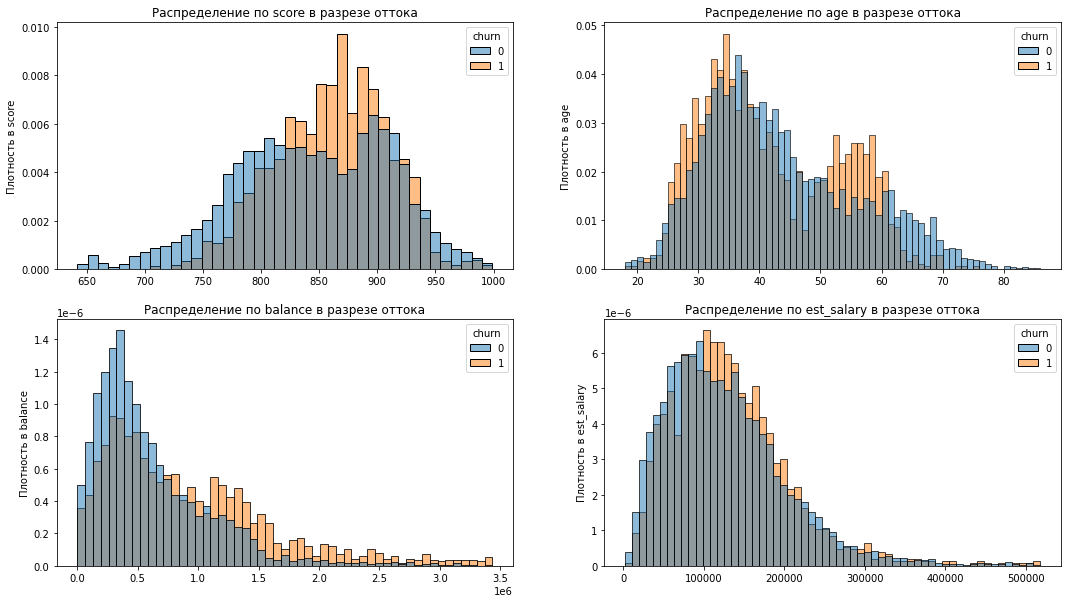

In [19]:
# задаем область графика
fig, ax = plt.subplots(figsize = (18, int(len(num_params)*2.5)))
i=1

# идем по кадому элементу списка num_params
for prm in num_params:
    
    if prm == 'age':
        sns.histplot(df, x=prm, 
                     hue='churn', 
                     stat='density', 
                     common_norm=False, 
                     binwidth=1,
                     ax = plt.subplot(int(len(num_params)/2), 2, i))
    else:
        sns.histplot(df, x=prm, 
                     hue='churn', 
                     stat='density', 
                     common_norm=False, 
                     ax = plt.subplot(int(len(num_params)/2), 2, i))
    
    plt.xlabel('')
    plt.ylabel(f'Плотность в {prm}')
    i += 1
    plt.title(f'Распределение по {prm} в разрезе оттока');

Для того чтобы подробнее описать графики и сделать выводы посмотрим на описательную статистику данных признаков.

In [20]:
# посмотрим на описательную статистику признаков отточных клиентов
display(df.query('churn == 1')[num_params].describe(percentiles=[0.05, 1/4, 1/2, 3/4, 0.95]))

,score,age,balance,est_salary
count,1744.00,1744.00,1735.00,1744.00
mean,860.55,41.32,914920.99,132703.91
std,47.85,11.16,693448.34,72176.06
min,706.00,18.00,6.00,10880.27
5%,779.00,26.00,128800.98,37899.94
25%,827.00,32.00,376848.30,81634.46
50%,864.50,39.00,754153.67,121968.61
75%,895.00,51.25,1287821.19,170418.48
95%,933.00,60.00,2365137.89,260958.41
max,999.00,75.00,3434496.57,511838.23


Характеристики отточных клиентов по межквартильному размаху по непрерывным признакам:
- По признаку `score`: от 828 до 897 баллов
- По признаку `age`: от 25 до 35 лет, а также 50-60 лет
- По признаку `balance`: от 377 тыс. руб. до 1,29 млн. руб.
- По признаку `est_salary`: примерно от 81 тыс.руб. до 170 тыс. руб.

**Категориальные признаки**

Проанализируем категориальные признаки из списка `cat_params`. На графики добавим прямую со средним уровнем оттока клиентов по банку. Будем считать, что если средний уровень оттока по признаку выше, чем общий средний отток, то такой признак оказывает сильное влияние на отток.

In [21]:
# средний уровеь оттока по банку
avg_churn = len(df.query('churn == 1'))/len(df)

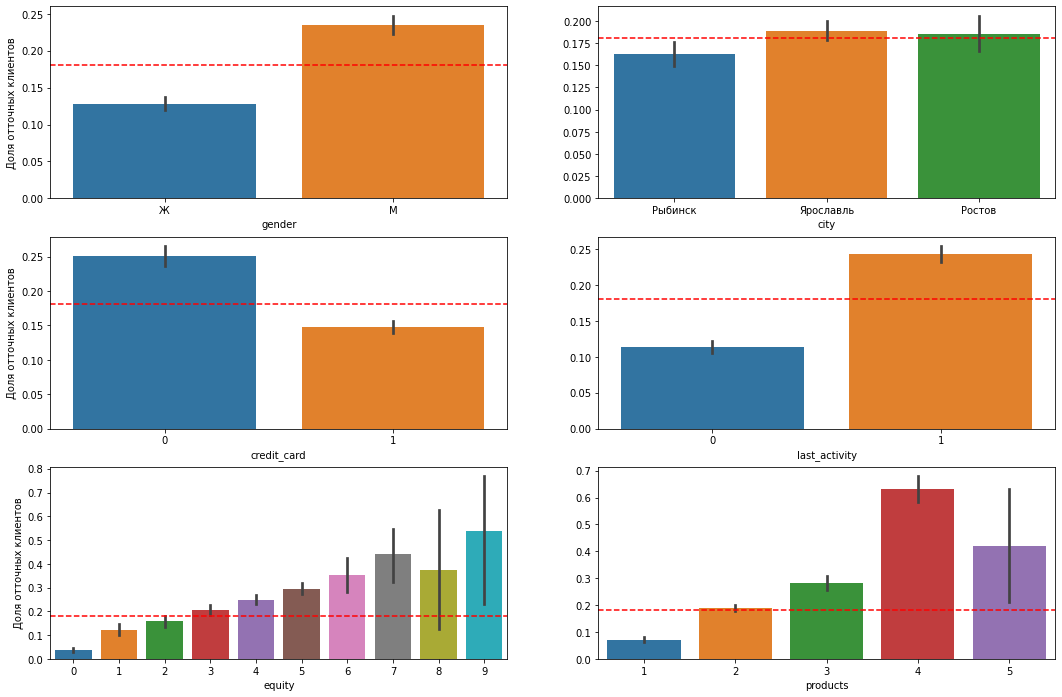

In [22]:
# задаем размер области графика
fig, ax = plt.subplots(figsize = (18, 12))

# итератор для расположения графика во 2-ом столбце области
i=1

# идем по элементам списка cat_params
for prm in cat_params:
    sns.barplot(data=df, x=prm, y='churn', ax = plt.subplot(int(len(cat_params)/2), 2, i))
    if i % 2 == 0:
        plt.ylabel('')
    else:
        plt.ylabel('Доля отточных клиентов')
    plt.axhline(y=avg_churn, color='red', linestyle='--');
    
    i += 1

Признаки клиентов, средний уровень отточности которых выше, чем общий средний уровень отточности (0.18):
- По признаку `gender`: Мужчины более склонны к оттоку (24% от всех клиентов)
- По признаку `city`: Клиенты из Ярославля и Ростова более склонны к оттоку (18%)
- По признаку `credit_card`: склонны к оттоку те, у кого нет кредитной карты (25%)
- По признаку `last_activity`: активные клиенты склонны к оттоку (24%)
- По признаку `products`: от 3 до 5 открытых продуктов (20-50% )
- По признаку `equity`: от 3 до 9 баллов собственности

Отток среди мужчин, клиентов без кредитной карты, активных клиентов, а также клиентов, пользующихся от 2 до 5 банковских продуктов и клиентов с баллами собственности от 3 до 9 выше, чем средний общий отток по банку.

### Анализ портретов клиентов в разрезе оттока

Составим портрет клиента в разрезе оттока. Для этого соберем меры центральной тенденции в сводной таблице по каждому признаку и посчитаем относительную разницу по лояльным и отточным клиентам. Напишем функцию, которая строит портрет клиента (на вход - датасет).

- Для непрерывных величин из `num_params` найдем среднее, а для `balance` и `est_salary` посчитаем медиану, так как в этих столбцах были найдены выбросы.
- Для категориальных величин посчитаем моду.

In [23]:
def get_client_portret(data):
    # непрерывные величины: центральная тенденция - средняя
    df_num_avg_churn = data.pivot_table(index='churn', 
                                        values=num_params, 
                                        aggfunc='mean').add_suffix('_avg').reset_index(drop=True).T

    # считаем разницу
    df_num_avg_churn['Относительная разница'] = df_num_avg_churn[1] - df_num_avg_churn[0]

    # display(df_num_avg_churn)

    # для est_salary и balance посчитаем медиану
    df_num_median_churn = data.pivot_table(index='churn', 
                                           values=num_params, 
                                           aggfunc='median').add_suffix('_median').reset_index(drop=True).T

    # считаем разницу
    df_num_median_churn['Относительная разница'] = df_num_median_churn[1] - df_num_median_churn[0]

    # display(df_num_median_churn)

    # категориальные величины: центральная тенденция - мода
    df_cat_mode_churn = data.pivot_table(index='churn',
                                         values=cat_params,
                                         aggfunc=lambda x: x.mode()[0]).add_suffix('_mode').reset_index(drop=True).T

    # display(df_cat_mode_churn)

    # соединияем таблицы
    df_pivot_churn = pd.concat([df_num_avg_churn, df_num_median_churn, df_cat_mode_churn])

    # переименуем столбцы
    df_pivot_churn.rename(columns={1: 'Отток',
                                   0: 'Не отток'}, inplace = True)

    display(df_pivot_churn)

In [24]:
get_client_portret(df)

,Не отток,Отток,Относительная разница
age_avg,42.98,41.32,-1.66
balance_avg,611698.91,914920.99,303222.07
est_salary_avg,127125.84,132703.91,5578.07
score_avg,844.07,860.55,16.48
age_median,40.00,39.00,-1.00
balance_median,468350.12,754153.67,285803.55
est_salary_median,115172.97,121968.61,6795.64
score_median,846.00,864.50,18.50
city_mode,Ярославль,Ярославль,NaN
credit_card_mode,1,1,NaN


Портрет **отточного** клиента банка - мужчина 41 год из Ярославля, имеющий кредитную карту, но активно пользующийся 2 банковскими продуктами. Его медианный доход около 120 тыс. руб., а на счету лежит примерно 750 тыс. руб., средний скоринговый балл - 860.

Портрет **лояльного** клиента банка - женщина 43 лет из Ярославля, имеющая кредитную карту, но активно не пользующаяся сервисами банка. У данного типа клиента открыто 2 продукта. Медианный доход - 115 тыс. руб., на счету хранится около 470 тыс. руб. Кредитный рейтинг ниже, чем у отточного клиента и составляет 844 балла.

### Корреляционный анализ

С помощью корреляционного анализа посмотрим, как признаки клиента влияют признак отточности. Оценку корреляции будем проводить по шкале Чеддока, а считать с помощью библиотеки `phik``.

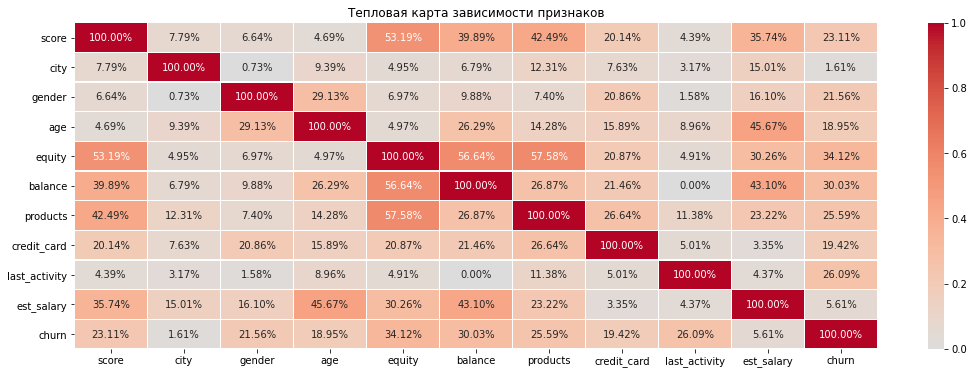

In [25]:
# применим метод phik
plt.figure(figsize=(18, 6))
sns.heatmap(df.drop(['user_id', 'balance_nan'], axis=1).phik_matrix(interval_cols=num_params),
            cmap='coolwarm',
            center=0, 
            annot=True, 
            linewidths=.2, 
            fmt='.2%')

plt.title('Тепловая карта зависимости признаков')
plt.show()

- Наблюдается заметная положительная зависимость между признаками `equity` и `score`, `products` и `equity`, `balance` и `equity`. Это может говорить о том, что чем больше собственности у клиента, тем выше балл и больше открытых продуктов. Умеренную положительную зависимость можно наблюдать по `age` и `est_salary`, то есть старшее поколение получает более высокую зарплату.
- Умеренная зависимость оттока наблюдается по признакам `balance` и `equity`. То есть, чем больше баллов собственности или выше баланс у клиента, тем больше отток. По остальным признакам корреляция с отточностью слабая.

Для трактовки силы связи между двумя наблюдаемыми величинами используем шкалу Чеддока. Она определяет тесноту связи следующим образом: 
- 0.1 – 0.3 – слабая; 
- 0.3 – 0.5 – умеренная; 
- 0.5 – 0.7 – заметная; 
- 0.7 – 0.9 – высокая; 
- 0.9 – 1 – весьма высокая

Границу между наличием и отсутствием связи между признаками определим на уровне 10%, то есть, если значение корреляции выше, чем 10%, то будем считать, что фактор *оказывает* влияние на признак. По полученному графику можно определить, что на отток влияют все признаки, кроме `city` и `est_salary`. Умеренная зависимость оттока (по шкале Чеддока) наблюдается по признакам `equity` и `balance`. По остальным признакам корреляция слабая.

## Проверка статистических гипотез

Нам необходимо проверить гипотезу о различии среднего дохода `est_salary` среди отточной и лояльной групп, а также гипотезу о различии среднего кредитного рейтинга `score` . Для определения и обоснования выбора инструментария для проверки гипотез нужно проверить данные на нормальность.

### Влияние дохода

Проверим данные `est_salary`на нормальность. Построим гистограмму распределения.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


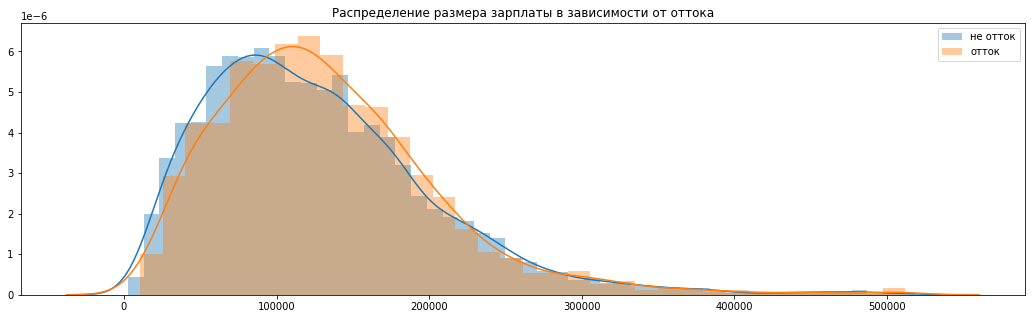

In [26]:
plt.figure(figsize=(18, 5))
sns.distplot(df[df['churn'] == 0]['est_salary'], label = 'не отток')
sns.distplot(df[df['churn'] == 1]['est_salary'], label = 'отток')

plt.title('Распределение размера зарплаты в зависимости от оттока')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

Графическая интерпретация говорит о том, что распределение нельзя считать нормальным.

- Тип данных: количественный, непрерывный, 
- Распределение: отличное от нормального, 
- Количество групп: 2, 
- Связанность групп: не связаны. 

Необходимо использовать непараметрический тест Манна-Уитни. Сформулируем гипотезы:
- **H0**: значимой разницы в среднем доходе между отточной и лояльной группами нет.
- **H1**: значимая разница в среднем доходе между двумя группами есть.

In [27]:
# уровень значимости
alpha = 0.05

results = st.mannwhitneyu(df.query('churn == 0')['est_salary'], df.query('churn == 1')['est_salary'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

print('-----')
print('Среднее значение дохода отточных клиентов:', round(df.query('churn == 1')['est_salary'].mean(), 2))
print('Среднее значение дохода лояльных клиентов:', round(df.query('churn == 0')['est_salary'].mean(), 2))

p-значение:  0.00010253787427758668
Отвергаем нулевую гипотезу: разница статистически значима
-----
Среднее значение дохода отточных клиентов: 132703.91
Среднее значение дохода лояльных клиентов: 127125.84


На имеющихся данных, на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о равенстве средних значений дохода отточных и лояльных клиентов в пользу альтернативной гипотезы. Скорее всего, различия будут закономерны, нежели случайными.

### Влияние креднитного рейтинга

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


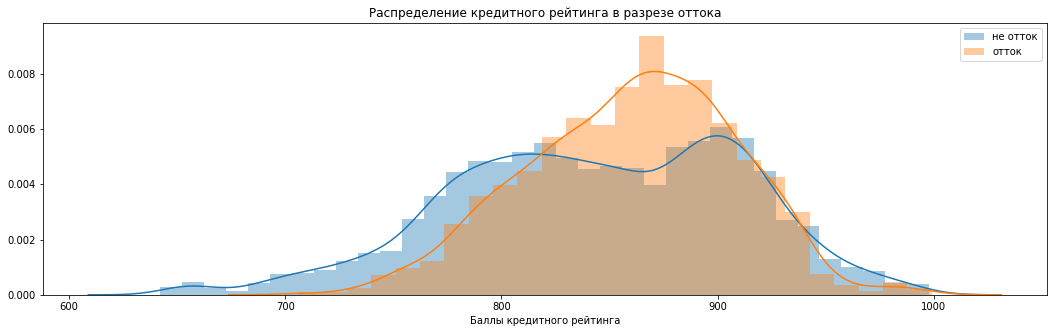

In [28]:
plt.figure(figsize=(18, 5))

sns.distplot(df[df['churn'] == 0]['score'], label = 'не отток')
sns.distplot(df[df['churn'] == 1]['score'], label = 'отток')

plt.title('Распределение кредитного рейтинга в разрезе оттока')
plt.xlabel('Баллы кредитного рейтинга')
plt.ylabel('')
plt.legend()
plt.show()

График показывает, что распределение нельзя считать нормальным.

- Тип данных: количественный, непрерывный, 
- Распределение: отличное от нормального, 
- Количество групп: 2, 
- Связанность групп: не связаны. 

Необходимо использовать непараметрический тест Манна-Уитни. Сформулируем гипотезы:
- **H0**: значимой разницы в среднем значении кредитного рейтинга между отточной и лояльной группами нет.
- **H1**: значимая разница в среднем значении кредитного рейтинга между двумя группами есть.

In [29]:
# уровень значимости
alpha = 0.05

results = st.mannwhitneyu(df.query('churn == 0')['score'], df.query('churn == 1')['score'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    )
    
print('-----')
print('Среднее значение кредитного рейтинга отточных клиентов:', round(df.query('churn == 1')['score'].mean(), 2))
print('Среднее значение кредитного рейтинга лояльных клиентов:', round(df.query('churn == 0')['score'].mean(), 2))

p-значение:  5.412328645243423e-19
Отвергаем нулевую гипотезу: разница статистически значима
-----
Среднее значение кредитного рейтинга отточных клиентов: 860.55
Среднее значение кредитного рейтинга лояльных клиентов: 844.07


На имеющихся данных, на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о равенстве средних значений кредитного рейтинга отточных и лояльных клиентов в пользу альтернативной гипотезы. Разница в скоринге между отточными и лояльными клиентами вероятнее будет закономерной, нежели слуйчайной.

## Выводы по EDA. Признаки, влияющие на отток

На данном этапе необходимо отобрать признаки оттока, которые лягут в основу сегментации клиентов.
Для отбора признаков будем опираться на результаты анализа распределения признаков по отточным клиентам, а также на данные портрета отточного клиента.

**Непрерывные признаки**

Построим графики распределения отточных и лояльных клиентов в разрезе непрерывных признаков в интервалах (межквартильных) признаков типичного отточного клиента. Определим доли оттока в банке по этим признакам.

churn,Не отток,Отток,Не отток %,Отток %
score,2609,879,74.80,25.20
balance,2979,867,77.46,22.54
est_salary,3595,872,80.48,19.52
age,4629,934,83.21,16.79


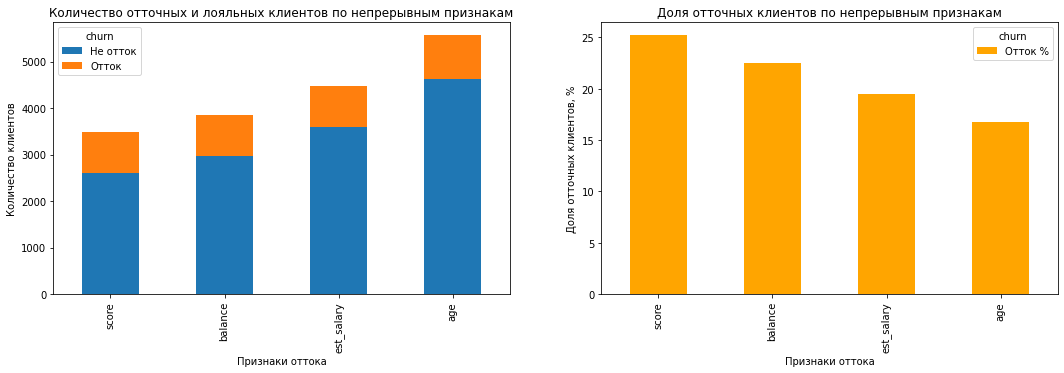

In [30]:
# создаем пустой df
df_pivot = pd.DataFrame()
    
for param in num_params:

    # определяем 25-й и 75-й перцентели
    p_25 = np.percentile(df.query(f'{param}.notna() and churn == 1')[param], 25)
    p_75 = np.percentile(df.query(f'{param}.notna() and churn == 1')[param], 75)

    # отбираем записи по 25 и 75 перцентилям
    df_p = df.query(f'{param} >= @p_25 and {param} <= @p_75')

    # строим pivot и круговую диаграмму
    df_p_new = df_p.pivot_table(index='churn', 
                                values='user_id',
                                aggfunc='count')
        
    df_p_new.rename(columns={'user_id': param}, inplace = True)
    df_pivot = pd.concat([df_pivot, df_p_new.T])

df_pivot.rename(columns={0: 'Не отток',
                         1: 'Отток'}, inplace = True)

df_pivot['Не отток %'] = df_pivot['Не отток'] / (df_pivot['Не отток'] + df_pivot['Отток']) * 100
df_pivot['Отток %'] = df_pivot['Отток'] / (df_pivot['Не отток'] + df_pivot['Отток']) * 100

df_pivot = df_pivot.sort_values(by='Отток %', ascending=False)

display(df_pivot)
df_pivot[['Не отток', 'Отток']].plot(kind='bar', stacked=True, figsize=(18,5), ax=plt.subplot(1, 2, 1))
plt.title('Количество отточных и лояльных клиентов по непрерывным признакам')
plt.ylabel('Количество клиентов')
plt.xlabel('Признаки оттока')

df_pivot[['Отток %']].plot(kind='bar', figsize=(18,5), ax=plt.subplot(1, 2, 2), color='orange')

plt.title('Доля отточных клиентов по непрерывным признакам')
plt.ylabel('Доля отточных клиентов, %')
plt.xlabel('Признаки оттока');

- В разрезе кредитного рейтинга `score` отток составляет 25.2%, интервал: от 828 до 897 баллов
- В разрезе возраста `age` отток составляет 16.79%, интервал: 25-35 года, а также 50-60 лет
- В разрезе баланса `balance` отток составляет 22.54%, интервал: 377 тыс. руб. - 1,29 млн. руб.
- В разрезе зарплаты `est_salary` отток составляет 19.52%, интервал:  81 тыс.руб. до 170 тыс. руб.

Обоснование отбора непрерывных критериев для сегментации:
- При EDA наблюдалась заметная разница по данным признакам между портретами клиентов в разрезе оттока, а также умеренная прямая зависимость у `equity`, `balance` с признаком оттока. Зависимость оттока и зарплат `est_salary` слабая, поэтому данный признак не будем рассматривать при сегментации клиентов;
- Проверка гипотез показала, что при наблюдении вероятнее всего разница в кредитном рейтинге `score` и в зарплате `est_salary` будет закономерной, чем случайной.

Так, из признаков, выражающихся **непрерывными** величинами, в целях сегментирования будем рассматривать **`score`**, **`balance`**, **`age`**.

In [31]:
# список непрерывных признаков для сегментации
# target_num_params = ['score', 'balance', 'age']
target_num_params = ['score', 'balance', 'age', 'est_salary']

**Категориальные признаки**

Ранее мы выяснили, что более склонны к оттоку - это мужчины, клиенты из Ярославля и Ростова, те, у кого нет кредитной карты, активные клиенты, клиенты, у которых от 2 до 3 открытых продуктов и у которых от 3 до 5 баллов собственности. Для сегментации найдем наибольшие доли и количество отточных клиентов по этим признакам, чтобы отобрать их для сегментации.

In [32]:
# идем по всем категориальным признакам
for param in cat_params:
    
    # найдем моду по признаку param
    clients_mode = df.query('churn == 1')[param].mode()[0]
    
    # найдем кол-во клиентов по моде
    clients_cnt = len(df.query(f'churn == 1 and {param} == @clients_mode')[param])
    
    # найдем долю клиентов среди
    clients_ratio = (clients_cnt / len(df.query('churn ==1')))*100
    print(f'Наибольший отток по признаку {param} со значением "{clients_mode}" составляет {clients_ratio:.2f}% ({clients_cnt} клиентов)')

Наибольший отток по признаку gender со значением "М" составляет 64.51% (1125 клиентов)
Наибольший отток по признаку city со значением "Ярославль" составляет 60.78% (1060 клиентов)
Наибольший отток по признаку credit_card со значением "1" составляет 55.62% (970 клиентов)
Наибольший отток по признаку last_activity со значением "1" составляет 70.01% (1221 клиентов)
Наибольший отток по признаку equity со значением "5" составляет 31.14% (543 клиентов)
Наибольший отток по признаку products со значением "2" составляет 54.13% (944 клиентов)


Большую долю отточных клиентов составляют мужчины (65%), 70% клиентов по признаку активности являются отточными, 55% клиентов, у кого есть кредитка, являются также отточными. В эту же группу попадают клиенты с 5 баллами собственности (31%). Клиенты, у которых открыто не более 2 продуктов, являются отточными. Самый высокий отток клиентов среди городов - в Ярославле (61%)

Отберем признаки в целях сегментирования, опираясь на следующие критерии:
- Отток клиентов по этим признакам выше, чем средний отток по банку;
- Прямая зависимость оттока от признаков должна быть близка к умеренной. 

Под данные критерии попадают `gender` (Мужчины), `last_activity` (активные), `credit_card`, `equity`, `products`

При выборе параметров признаков в сегментировании будем опираться на значения, по которым наблюдается набольший отток.

In [33]:
# списки категориальных признаков для сегментации
target_cat_params = ['gender', 'last_activity', 'credit_card', 'equity', 'products']

## Сегментация клиентов

По выявленным признакам, которые характеризуются высоким уровнем оттока, построим 3 сегмента отточных пользователей для разработки рекоммендаций по их удержанию. Отберем сегменты, которые удовлетворяют следующим критериям:
- Уровень оттока в сегменте должен быть выше среднебанковского
- Сегмент должен включать не менее 500 клиентов

Далее дадим характеристику сегменту, составим портрет отточного клиента и разработаем рекомендации по работе с этими сегментами клиентов.

Для отбора сегментов, удовлетворяющих нашим критериям, напишем функцию, которая принимает список признаков с целевыми значениями, при которых наблюдался выоский уровень оттока, и минимальное количество комбинируемых признаков (по умолчанию - 2). Возвращать эта функция будет комбинацию из признаков, по которым нашелся отточный сегмент.

In [34]:
def get_segment(lst_params, min_params=2):
    
    # кол-во отточных клиентов по банку
    clients_churn_total = len(df.query('churn == 1'))

    # счетчик сегментов, удовлетворяющих условие
    cnt_seg_true = 0
    
    # список номеров сегментов (ID)
    seg_num = 0
    seg_num_list = []
    
    # список долей оттока
    seg_churn_ratio_list = []

    # находим комбинации сочетания признаков
    for i in range(min_params, len(churn_params)):

        combinations = list(itertools.combinations(churn_params, i))
        
        for comb in combinations: # идем по каждой комбинации

            df_seg = df
            seg_num += 1

            for elem in comb: # идем по каждому элементу (признаку) в комбинации
                #print(f'Признак: {elem}')
                param_name = elem[1] # имя параметра
                param_value = elem[2] # значение признака

                if elem[0] == 'cat': # фильтруем по категориальным признакам
                    df_seg = df_seg.query(f'{param_name} == @param_value')
                elif elem[0] == 'num': # фильтруем по непрерывным признакам
                    param_value_min = param_value[0]
                    param_value_max = param_value[1]
                    df_seg = df_seg.query(f'{param_name} >= @param_value_min and {param_name} <= @param_value_max')

            clients_total = len(df_seg) # кол-во клиентов в сегменте
            seg_clients_churn = len(df_seg.query('churn == 1')) # кол-во отточных клиентов в сегменте
            seg_churn_ratio = seg_clients_churn / clients_churn_total # доля отточных по банку
            
            # накладываем критерии для сегмента
            if clients_total >= 500 and seg_churn_ratio > avg_churn:

                cnt_seg_true += 1 # увеличиваем счетчик сегментов, прошедших по условию
                seg_num_list.append(seg_num)
                seg_churn_ratio_list.append(round(seg_churn_ratio, 2))
                
                print(f'Сегмент (ID: {seg_num})')
                print(f'Признаки сегмента: {comb}')
                print(f'Размер сегмента: {clients_total}')
                print(f'Отточных клиентов в сегменте: {seg_clients_churn}')
                print(f'Доля отточных клиентов сегмента по банку: {seg_churn_ratio*100:.2f}% \n')
                print(f'Портрет клиента по сегменту')
                
                # выводим портет клиента сегмента
                get_client_portret(df_seg)
                
                print('-' * 10, '\n')
                
    print(f'Количество сегментов, удовлетворяющих условию: {cnt_seg_true}')
    print('ТОП сегментов (доля оттока, ID):', sorted(zip(seg_churn_ratio_list, seg_num_list), reverse=True)[:3])

Рассмотрим сегменты по двум спискам с параметром `lst_params` = 3, так как комбинация, состоящая из трех критериев не позволит сегментировать широкими мазкам, но и в то же время не даст сузить сегменты:
- Категориальные признаки с модальными значениями, которые дают наибольший отток. Непрерывные признаки с межкартильным интервалом в разрезе отточных клиентов;
- По признакам `equity` и `products` возьмем межквартильный интервал значений в разрезе отточных клиентов.

In [35]:
# смотрим сегменты по первому списку
# тип признака / признак / модальное, целевое значение признака
churn_params = [['cat', 'gender', 'M'], 
                ['cat', 'last_activity', 1], 
                ['cat', 'credit_card', 1],
                ['cat', 'equity', 5], 
                ['cat', 'products', 2],
                ['num', 'age', [25, 35]],
                ['num', 'score', [828, 897]],
                ['num', 'balance', [377, 1290]],
                ['num', 'est_salary', [81000, 170000]]]

get_segment(churn_params, 3)

Сегмент (ID: 32)
Признаки сегмента: (['cat', 'last_activity', 1], ['cat', 'credit_card', 1], ['num', 'score', [828, 897]])
Размер сегмента: 1052
Отточных клиентов в сегменте: 335
Доля отточных клиентов сегмента по банку: 19.21% 

Портрет клиента по сегменту


,Не отток,Отток,Относительная разница
age_avg,42.55,37.76,-4.78
balance_avg,580144.38,767307.97,187163.59
est_salary_avg,110991.64,129816.13,18824.49
score_avg,862.68,865.06,2.38
age_median,39.00,35.00,-4.00
balance_median,490107.16,650433.36,160326.20
est_salary_median,97919.01,122505.86,24586.85
score_median,861.00,866.00,5.00
city_mode,Ярославль,Ярославль,NaN
credit_card_mode,1,1,NaN


---------- 

Сегмент (ID: 34)
Признаки сегмента: (['cat', 'last_activity', 1], ['cat', 'credit_card', 1], ['num', 'est_salary', [81000, 170000]])
Размер сегмента: 1555
Отточных клиентов в сегменте: 331
Доля отточных клиентов сегмента по банку: 18.98% 

Портрет клиента по сегменту


,Не отток,Отток,Относительная разница
age_avg,41.85,39.02,-2.83
balance_avg,563601.21,789131.01,225529.80
est_salary_avg,122719.88,123418.07,698.19
score_avg,832.48,859.00,26.52
age_median,39.00,37.00,-2.00
balance_median,442728.62,677637.65,234909.03
est_salary_median,122262.88,120943.99,-1318.88
score_median,826.00,863.00,37.00
city_mode,Ярославль,Ярославль,NaN
credit_card_mode,1,1,NaN


---------- 

Сегмент (ID: 41)
Признаки сегмента: (['cat', 'last_activity', 1], ['cat', 'products', 2], ['num', 'score', [828, 897]])
Размер сегмента: 982
Отточных клиентов в сегменте: 431
Доля отточных клиентов сегмента по банку: 24.71% 

Портрет клиента по сегменту


,Не отток,Отток,Относительная разница
age_avg,46.71,39.33,-7.37
balance_avg,641880.25,845175.97,203295.72
est_salary_avg,105558.18,128622.56,23064.39
score_avg,856.69,866.71,10.02
age_median,44.00,36.00,-8.00
balance_median,556438.61,724111.22,167672.61
est_salary_median,91676.47,120960.23,29283.76
score_median,853.00,868.00,15.00
city_mode,Рыбинск,Ярославль,NaN
credit_card_mode,1,0,NaN


---------- 

Сегмент (ID: 43)
Признаки сегмента: (['cat', 'last_activity', 1], ['cat', 'products', 2], ['num', 'est_salary', [81000, 170000]])
Размер сегмента: 1278
Отточных клиентов в сегменте: 385
Доля отточных клиентов сегмента по банку: 22.08% 

Портрет клиента по сегменту


,Не отток,Отток,Относительная разница
age_avg,43.32,40.04,-3.28
balance_avg,601887.03,877513.10,275626.08
est_salary_avg,119367.49,122788.99,3421.50
score_avg,825.40,868.31,42.90
age_median,41.00,36.00,-5.00
balance_median,475354.80,786911.18,311556.38
est_salary_median,116997.22,120587.59,3590.37
score_median,816.00,871.00,55.00
city_mode,Ярославль,Ярославль,NaN
credit_card_mode,1,0,NaN


---------- 

Сегмент (ID: 48)
Признаки сегмента: (['cat', 'last_activity', 1], ['num', 'score', [828, 897]], ['num', 'est_salary', [81000, 170000]])
Размер сегмента: 840
Отточных клиентов в сегменте: 369
Доля отточных клиентов сегмента по банку: 21.16% 

Портрет клиента по сегменту


,Не отток,Отток,Относительная разница
age_avg,44.59,39.76,-4.82
balance_avg,672348.93,831315.77,158966.85
est_salary_avg,120335.25,124173.88,3838.62
score_avg,862.50,866.92,4.42
age_median,42.00,37.00,-5.00
balance_median,568781.89,755344.01,186562.12
est_salary_median,118239.49,123661.21,5421.72
score_median,862.00,868.00,6.00
city_mode,Ярославль,Ярославль,NaN
credit_card_mode,1,0,NaN


---------- 

Количество сегментов, удовлетворяющих условию: 5
ТОП сегментов (доля оттока, ID): [(0.25, 41), (0.22, 43), (0.21, 48)]


In [36]:
# смотрим сегменты по второму списку
churn_params = [['cat', 'gender', 'M'], 
                ['cat', 'last_activity', 1], 
                ['cat', 'credit_card', 1],
                ['num', 'equity', [3, 5]], 
                ['num', 'products', [2, 3]],
                ['num', 'age', [50, 60]],
                ['num', 'score', [828, 897]],
                ['num', 'balance', [377, 1290],
                ['num', 'est_salary', [81000, 170000]]]]
                
get_segment(churn_params, 3)

Сегмент (ID: 22)
Признаки сегмента: (['cat', 'last_activity', 1], ['cat', 'credit_card', 1], ['num', 'equity', [3, 5]])
Размер сегмента: 1587
Отточных клиентов в сегменте: 462
Доля отточных клиентов сегмента по банку: 26.49% 

Портрет клиента по сегменту


,Не отток,Отток,Относительная разница
age_avg,42.82,39.17,-3.64
balance_avg,663494.99,937857.48,274362.50
est_salary_avg,102245.85,136204.46,33958.62
score_avg,832.54,866.25,33.71
age_median,40.00,37.00,-3.00
balance_median,545455.53,798971.67,253516.14
est_salary_median,92357.94,125851.42,33493.48
score_median,825.00,870.00,45.00
city_mode,Ярославль,Ярославль,NaN
credit_card_mode,1,1,NaN


---------- 

Сегмент (ID: 23)
Признаки сегмента: (['cat', 'last_activity', 1], ['cat', 'credit_card', 1], ['num', 'products', [2, 3]])
Размер сегмента: 1670
Отточных клиентов в сегменте: 341
Доля отточных клиентов сегмента по банку: 19.55% 

Портрет клиента по сегменту


,Не отток,Отток,Относительная разница
age_avg,42.77,39.22,-3.55
balance_avg,555851.35,766731.26,210879.91
est_salary_avg,107141.31,126719.95,19578.64
score_avg,826.56,852.46,25.90
age_median,40.00,36.00,-4.00
balance_median,435074.69,645696.34,210621.65
est_salary_median,97517.28,115956.14,18438.86
score_median,816.00,857.00,41.00
city_mode,Ярославль,Ярославль,NaN
credit_card_mode,1,1,NaN


---------- 

Сегмент (ID: 25)
Признаки сегмента: (['cat', 'last_activity', 1], ['cat', 'credit_card', 1], ['num', 'score', [828, 897]])
Размер сегмента: 1052
Отточных клиентов в сегменте: 335
Доля отточных клиентов сегмента по банку: 19.21% 

Портрет клиента по сегменту


,Не отток,Отток,Относительная разница
age_avg,42.55,37.76,-4.78
balance_avg,580144.38,767307.97,187163.59
est_salary_avg,110991.64,129816.13,18824.49
score_avg,862.68,865.06,2.38
age_median,39.00,35.00,-4.00
balance_median,490107.16,650433.36,160326.20
est_salary_median,97919.01,122505.86,24586.85
score_median,861.00,866.00,5.00
city_mode,Ярославль,Ярославль,NaN
credit_card_mode,1,1,NaN


---------- 

Сегмент (ID: 27)
Признаки сегмента: (['cat', 'last_activity', 1], ['num', 'equity', [3, 5]], ['num', 'products', [2, 3]])
Размер сегмента: 1964
Отточных клиентов в сегменте: 678
Доля отточных клиентов сегмента по банку: 38.88% 

Портрет клиента по сегменту


,Не отток,Отток,Относительная разница
age_avg,45.21,40.19,-5.03
balance_avg,704838.56,1021490.32,316651.77
est_salary_avg,103378.50,135451.37,32072.87
score_avg,829.48,870.65,41.18
age_median,42.00,37.00,-5.00
balance_median,589728.81,880714.57,290985.76
est_salary_median,93534.91,125985.05,32450.14
score_median,822.00,873.00,51.00
city_mode,Ярославль,Ярославль,NaN
credit_card_mode,1,0,NaN


---------- 

Сегмент (ID: 29)
Признаки сегмента: (['cat', 'last_activity', 1], ['num', 'equity', [3, 5]], ['num', 'score', [828, 897]])
Размер сегмента: 1185
Отточных клиентов в сегменте: 542
Доля отточных клиентов сегмента по банку: 31.08% 

Портрет клиента по сегменту


,Не отток,Отток,Относительная разница
age_avg,45.55,39.60,-5.95
balance_avg,690466.68,907858.71,217392.04
est_salary_avg,102608.12,131485.78,28877.66
score_avg,856.13,867.32,11.19
age_median,42.00,37.00,-5.00
balance_median,586383.75,777590.93,191207.18
est_salary_median,89543.43,126891.11,37347.68
score_median,853.00,868.50,15.50
city_mode,Ярославль,Ярославль,NaN
credit_card_mode,1,0,NaN


---------- 

Сегмент (ID: 32)
Признаки сегмента: (['cat', 'last_activity', 1], ['num', 'products', [2, 3]], ['num', 'score', [828, 897]])
Размер сегмента: 1104
Отточных клиентов в сегменте: 501
Доля отточных клиентов сегмента по банку: 28.73% 

Портрет клиента по сегменту


,Не отток,Отток,Относительная разница
age_avg,47.63,39.70,-7.93
balance_avg,652164.76,852052.84,199888.08
est_salary_avg,105447.16,129892.99,24445.84
score_avg,856.30,866.29,9.99
age_median,45.00,37.00,-8.00
balance_median,557819.77,732523.83,174704.06
est_salary_median,91520.67,122505.86,30985.19
score_median,853.00,868.00,15.00
city_mode,Ярославль,Ярославль,NaN
credit_card_mode,1,0,NaN


---------- 

Сегмент (ID: 37)
Признаки сегмента: (['cat', 'credit_card', 1], ['num', 'equity', [3, 5]], ['num', 'products', [2, 3]])
Размер сегмента: 2169
Отточных клиентов в сегменте: 381
Доля отточных клиентов сегмента по банку: 21.85% 

Портрет клиента по сегменту


,Не отток,Отток,Относительная разница
age_avg,42.44,41.09,-1.34
balance_avg,713314.64,808761.61,95446.97
est_salary_avg,108298.63,123872.07,15573.44
score_avg,840.61,846.84,6.23
age_median,40.00,38.00,-2.00
balance_median,592540.22,657708.00,65167.78
est_salary_median,97688.28,115986.67,18298.39
score_median,836.00,849.00,13.00
city_mode,Ярославль,Ярославль,NaN
credit_card_mode,1,1,NaN


---------- 

Сегмент (ID: 39)
Признаки сегмента: (['cat', 'credit_card', 1], ['num', 'equity', [3, 5]], ['num', 'score', [828, 897]])
Размер сегмента: 1401
Отточных клиентов в сегменте: 354
Доля отточных клиентов сегмента по банку: 20.30% 

Портрет клиента по сегменту


,Не отток,Отток,Относительная разница
age_avg,42.78,39.43,-3.35
balance_avg,674499.93,849327.62,174827.69
est_salary_avg,107638.71,130263.60,22624.89
score_avg,859.75,865.25,5.50
age_median,40.00,37.00,-3.00
balance_median,586813.83,710839.33,124025.51
est_salary_median,96682.60,122702.62,26020.02
score_median,859.00,866.00,7.00
city_mode,Ярославль,Ярославль,NaN
credit_card_mode,1,1,NaN


---------- 

Сегмент (ID: 48)
Признаки сегмента: (['num', 'equity', [3, 5]], ['num', 'products', [2, 3]], ['num', 'score', [828, 897]])
Размер сегмента: 1728
Отточных клиентов в сегменте: 512
Доля отточных клиентов сегмента по банку: 29.36% 

Портрет клиента по сегменту


,Не отток,Отток,Относительная разница
age_avg,44.77,41.01,-3.76
balance_avg,726102.75,913340.25,187237.50
est_salary_avg,109395.49,129747.13,20351.64
score_avg,859.91,866.15,6.23
age_median,42.00,39.00,-3.00
balance_median,627262.41,794854.18,167591.77
est_salary_median,97067.72,122877.67,25809.95
score_median,859.00,867.50,8.50
city_mode,Ярославль,Ярославль,NaN
credit_card_mode,1,0,NaN


---------- 

Сегмент (ID: 103)
Признаки сегмента: (['cat', 'last_activity', 1], ['num', 'equity', [3, 5]], ['num', 'products', [2, 3]], ['num', 'score', [828, 897]])
Размер сегмента: 836
Отточных клиентов в сегменте: 402
Доля отточных клиентов сегмента по банку: 23.05% 

Портрет клиента по сегменту


,Не отток,Отток,Относительная разница
age_avg,47.68,39.92,-7.75
balance_avg,729123.63,912463.68,183340.06
est_salary_avg,107848.32,130467.49,22619.17
score_avg,855.77,867.76,11.99
age_median,45.50,37.00,-8.50
balance_median,633555.75,794854.18,161298.43
est_salary_median,93130.33,123738.24,30607.90
score_median,852.00,869.00,17.00
city_mode,Ярославль,Ярославль,NaN
credit_card_mode,1,0,NaN


---------- 

Количество сегментов, удовлетворяющих условию: 10
ТОП сегментов (доля оттока, ID): [(0.39, 27), (0.31, 29), (0.29, 48)]


При расширении диапазона признаков расширилось количество сегментов. Остановимся на 1 сегменте из первого списка (ID: 41), на 3 сегментах (ID: 27, 29, 48) из второго списка. В них наблюдается высокая доля отточности. В каждом сегменте не более трех признаков разного типа. Посмотрим на портреты клиентов в них.

**Сегмент 41**. (Размер: 982, отточных клиентов: 431, доля оттока сегмента по банку: 25%)
 - Портрет отточного клиента: мужчина, средний возраст 39 лет, зарплата 120 тыс. руб., на балансе около 725 тыс. руб., активный клиент, пользующийся двумя продуктами, без оформленной кредитной карты, с высоким кредитным рейтингом (868), высокий балл собственности (5).


**Сегмент 27**. (Размер: 1964, отточных клиентов: 678, доля оттока сегмента по банку: 39%)
 - Портрет отточного клиента: мужчина, средний возраст 40 лет, зарплата около 126 тыс. руб., на балансе около 880 тыс. руб., активный клиент, пользующийся двумя продуктами, без оформленной кредитной карты, с высоким кредитным рейтингом (870), высокий балл собственности (5).


**Сегмент 29**. (Размер: 1185, отточных клиентов: 542, доля оттока сегмента по банку: 31%)
 - Портрет отточного клиента: мужчина, средний возраст 40 лет, зарплата около 127 тыс. руб., на балансе около 777 тыс. руб., активный клиент, пользующийся двумя продуктами, без оформленной кредитной карты, с высоким кредитным рейтингом (867), высокий балл собственности (5).

 
**Сегмент 48**. (Размер: 1727, отточных клиентов: 512, доля оттока сегмента по банку: 29%)
 - Портрет отточного клиента: мужчина, средний возраст 41 год, зарплата около 129 тыс. руб., на балансе около 794 тыс. руб., активный клиент, пользующийся двумя продуктами, без оформленной кредитной карты, с достаточно высоким кредитным рейтингом (866), высокий балл собственности (5).

 
Общие черты отточных клиентов по сегментам: активный клиент, мужчина, 39-41 год, зарплата 120-130 тыс. руб., на балансе примерно 6 зарплат, высокий кредитный рейтинг, высокий балл собственности, нет кредитной карты.

## Приоритизация сегментов

Важно отметить, что отдел маректинга включает только двух работников, у них нет автоматизированных систем, поэтому все мероприятия, рассылки и агитации будут выполнены ручным трудом. Поэтому важно приоритизировать сегменты, чтобы маркетинг знал, на что обратить внимание в первую очередь в случае, если ресурсов маркетинга не хватит на охват всех выделенных сегментов.

Приоритизируем сегменты по мере убывания отточных клиентов: 27 (38.8%), 29 (31%), 48 (29.36%), 41 (25%).

## Рекомендации по работе с сегментами

- **Сегмент 27**. Прежде всего стоит обратить внимание на мужчин 40 лет с зарплатой около 126 тыс. руб., не пользующихся кредитными картами, с более высоким кредитным рейтингом. Таким клиентам нужно делать упор на кредитные продукты. Также у клиентов на балансе лежит наибольшая сумма среди рассматриваемых сегментов.
- **Сегмент 29**. Наиболее сбалансированный сегмент с точки зрения баланса и зарплаты. Здесь также стоит обратить внимание на мужчин 40 лет и попытаться вернуть их в категорию лояльных клиентов через повышенные ставки кешбэка, проценты по депозитам;
- **Сегмент 48**. Сегмент не очень сильно отличается от остальных, поэтому рекомендации здесь те же, что и в предыдущих двух;
- **Сегмент 41**. Клиентам данного сегмента стоит в первую очередь предложить открыть кредитные карты, так как более низкий баланс и зарплата, чем у других сегментов, может означать недостаток средств на приобретение каких-либо товаров. 

Для всех сегментов также будет актуально предлагать открыть новый кредитный продукт, так как у всех высокий кредитный рейтинг. С учетом отсутствия кредитной карты - нужно начать с нее. Для лояльности необходимо ввести льготные условия по кредитным/дебетовым продуктам.

## Выводы и рекомендации

Перед нами была поставлена цель разработать рекомендации по работе с отточными клиентами для отдела маркетинга банка "Метанпромбанк". Для достижения цели нами было сделано следующее:

1. Проанализировали датасет с характеристиками клиентов банка "Метанпромбанк", которые обслуживаются в отделениях Ярославской области (в Ярославле, Рыбинске и Ростове). В целях получения более точных результатов исследования было принято решение об удалении записей с пропусками в `age`, записи с аномальными значениями в `balance` и `est_salary` выше 98 перцентиля.


2. **Анализ признаков оттока**. Разделили признаки на категориальные и непрерывные, определили модальные (по категориальным), средние и медианные значения (по непрерывным величинам) отточных клиентов. Составили портрет лояльного и отточного клиента:
 - Портрет **отточного** клиента банка - мужчина 41 год из Ярославля, имеющий кредитную карту, но активно пользующийся 2 банковскими продуктами. Его медианный доход около 120 тыс. руб., а на счету лежит примерно 750 тыс. руб., средний скоринговый балл - 860.
 - Портрет **лояльного** клиента банка - женщина 43 лет из Ярославля, имеющая кредитную карту, но активно не пользующаяся сервисами банка. У данного типа клиента открыто 2 продукта. Медианный доход - 115 тыс. руб., на счету хранится около 470 тыс. руб. Кредитный рейтинг ниже, чем у отточного клиента и составляет 844 балла.


3. **Корреляция**. Провели оценку корреляции признаков клиентов с отточностью. Умеренная зависимость оттока наблюдается по признакам `balance` и `equity` (по шкале Чеддока). То есть, чем больше баллов собственности или выше баланс у клиента, тем больше отток. По остальным признакам корреляция с отточностью слабая. Все признаки, за исключением `city`и `est_salary` оказывают влияние на отток.


4. **Проверка гипотез**. Проверены две гипотезы:
 - гипотеза различия зарплты между отточными и лояльными клиентами банка. Получилось, что разница в скоринге между отточными и лояльными клиентами вероятнее будет закономерной, нежели слуйчайной;
 - гипотеза различия в скоринговом балле отточных и лояльных клиентов банка. Получилось, что разница в скоринге между отточными и лояльными клиентами также вероятнее будет закономерной, нежели слуйчайной.
 

5. **Итоги по EDA**, в целях поиска отточных сегментов отобрали признаки, которые наиболее сильно влияют на отток: наличие кредитной карты, активность, скоринговый балл, баланс, возраст, баллы собственности, пол.


6. **Сегментация**. Определили 4 наиболее отточных сегмента (по приоретизации):
 - Сегмент 27. Размер: 1964, отточных клиентов: 678, доля оттока сегмента по банку: 38.8%
 - Сегмент 29. Размер: 1185, отточных клиентов: 542, доля оттока сегмента по банку: 31%
 - Сегмент 48. Размер: 1727, отточных клиентов: 512, доля оттока сегмента по банку: 29.36%
 - Сегмент 41. Размер: 982, отточных клиентов: 431, доля оттока сегмента по банку: 25%
 
Общие черты отточных клиентов по сегментам: активный клиент, мужчина, 39-41 год, зарплата 120-130 тыс. руб., на балансе примерно 6 зарплат, высокий кредитный рейтинг, высокий балл собственности, нет кредитной карты.
 
**Рекомендации**

- Стоит обратить внимание на удержание активных клиентов среди мужчин 40 лет с зарплатой 120-130 тыс. руб., обслуживающихся в Ярославле, с накоплениями "на черный день".
- В силу высокого кредитного рейтинга, высокой зарплаты и отсутствия кредитных карт у клиентов в этом сегменте, следует мотивировать клиентов открывать кредитные карты;
- Стараться удержать или вернуть активных клиентов через предоставление льготных условий по кредитным программам, повышенные ставки по депозитам, открыть категории с повышенным кешбэком.